In [3]:
# Import necessary libraries
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.utils as image
import numpy as np
import matplotlib.pyplot as plt
import itertools
import cv2
from os import listdir
from os.path import isfile, join
from IPython.display import Image, display

In [ ]:
from os import listdir
from os.path import join
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

image_dir = 'data/MouldImages/train/mould/'
files = listdir(image_dir)
img_paths = [join(image_dir, f) for f in files[0:9]]

for i, img_path in enumerate(img_paths):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    display(Image(filename=img_path, width=224, height=224))


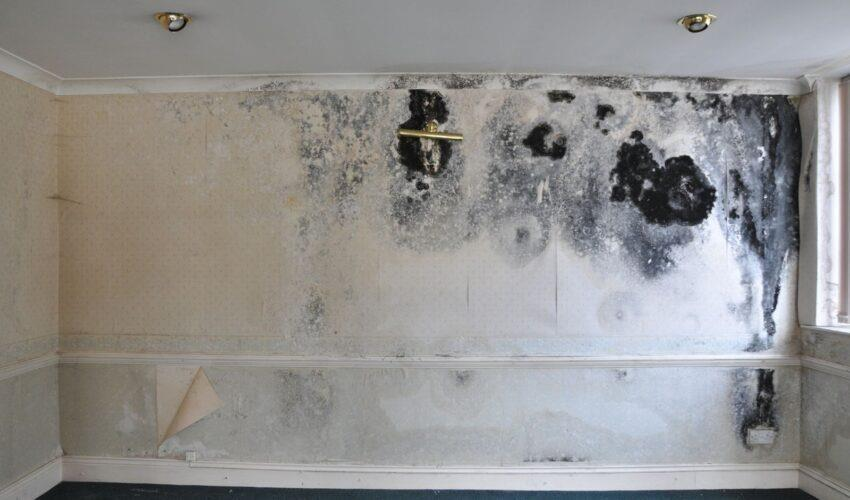

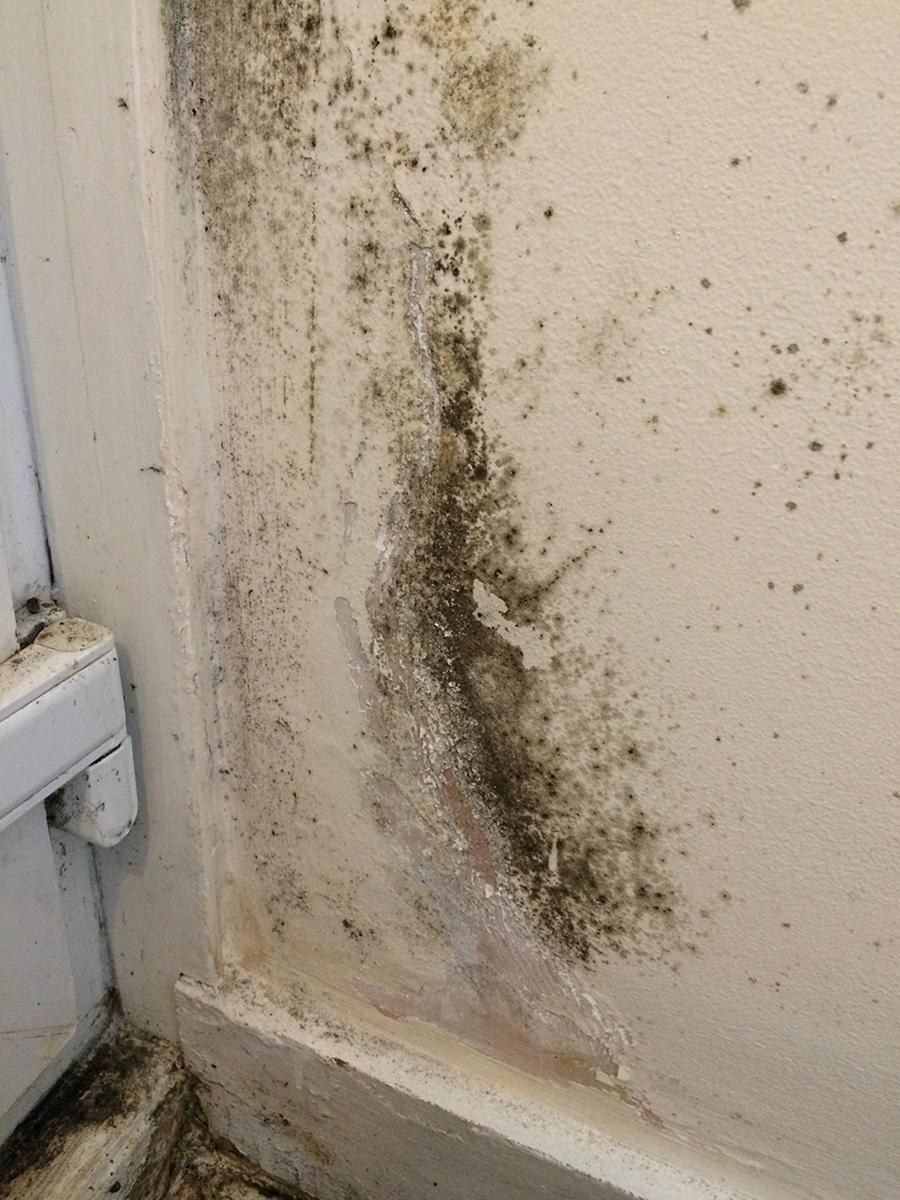

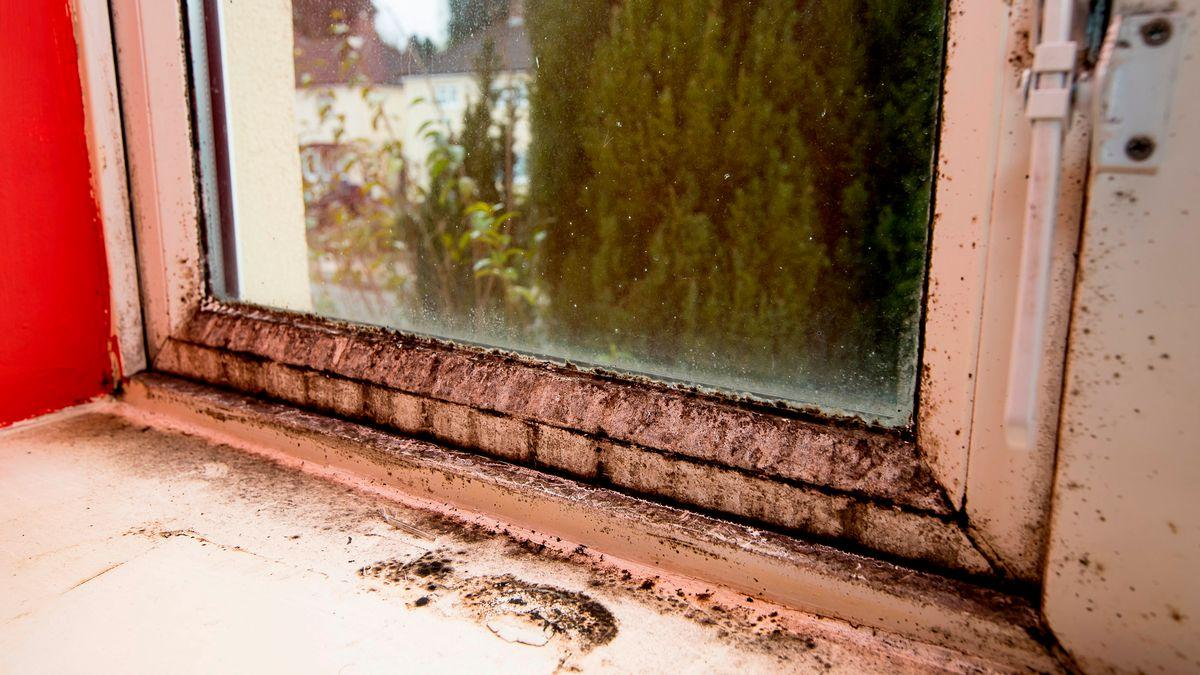

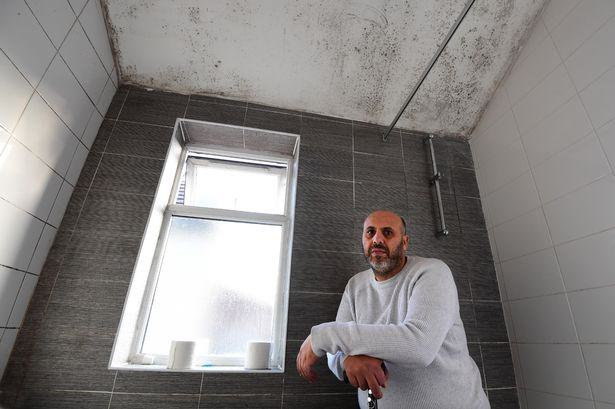

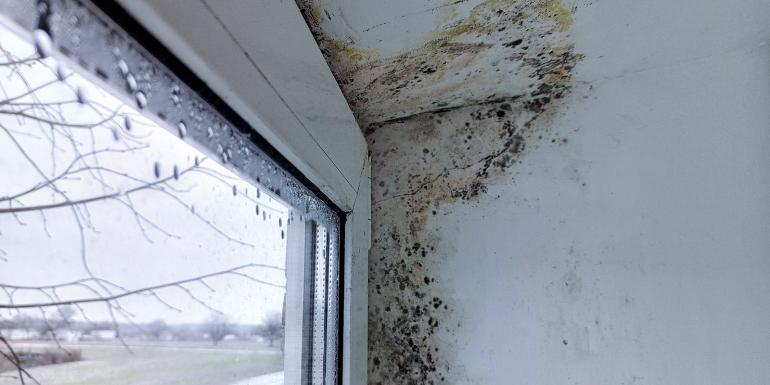

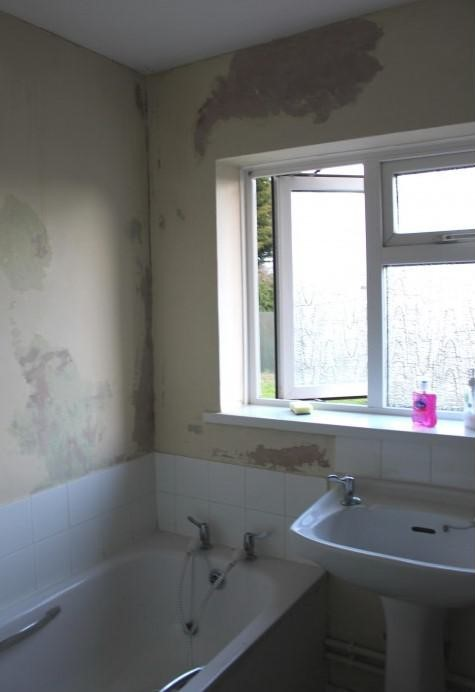

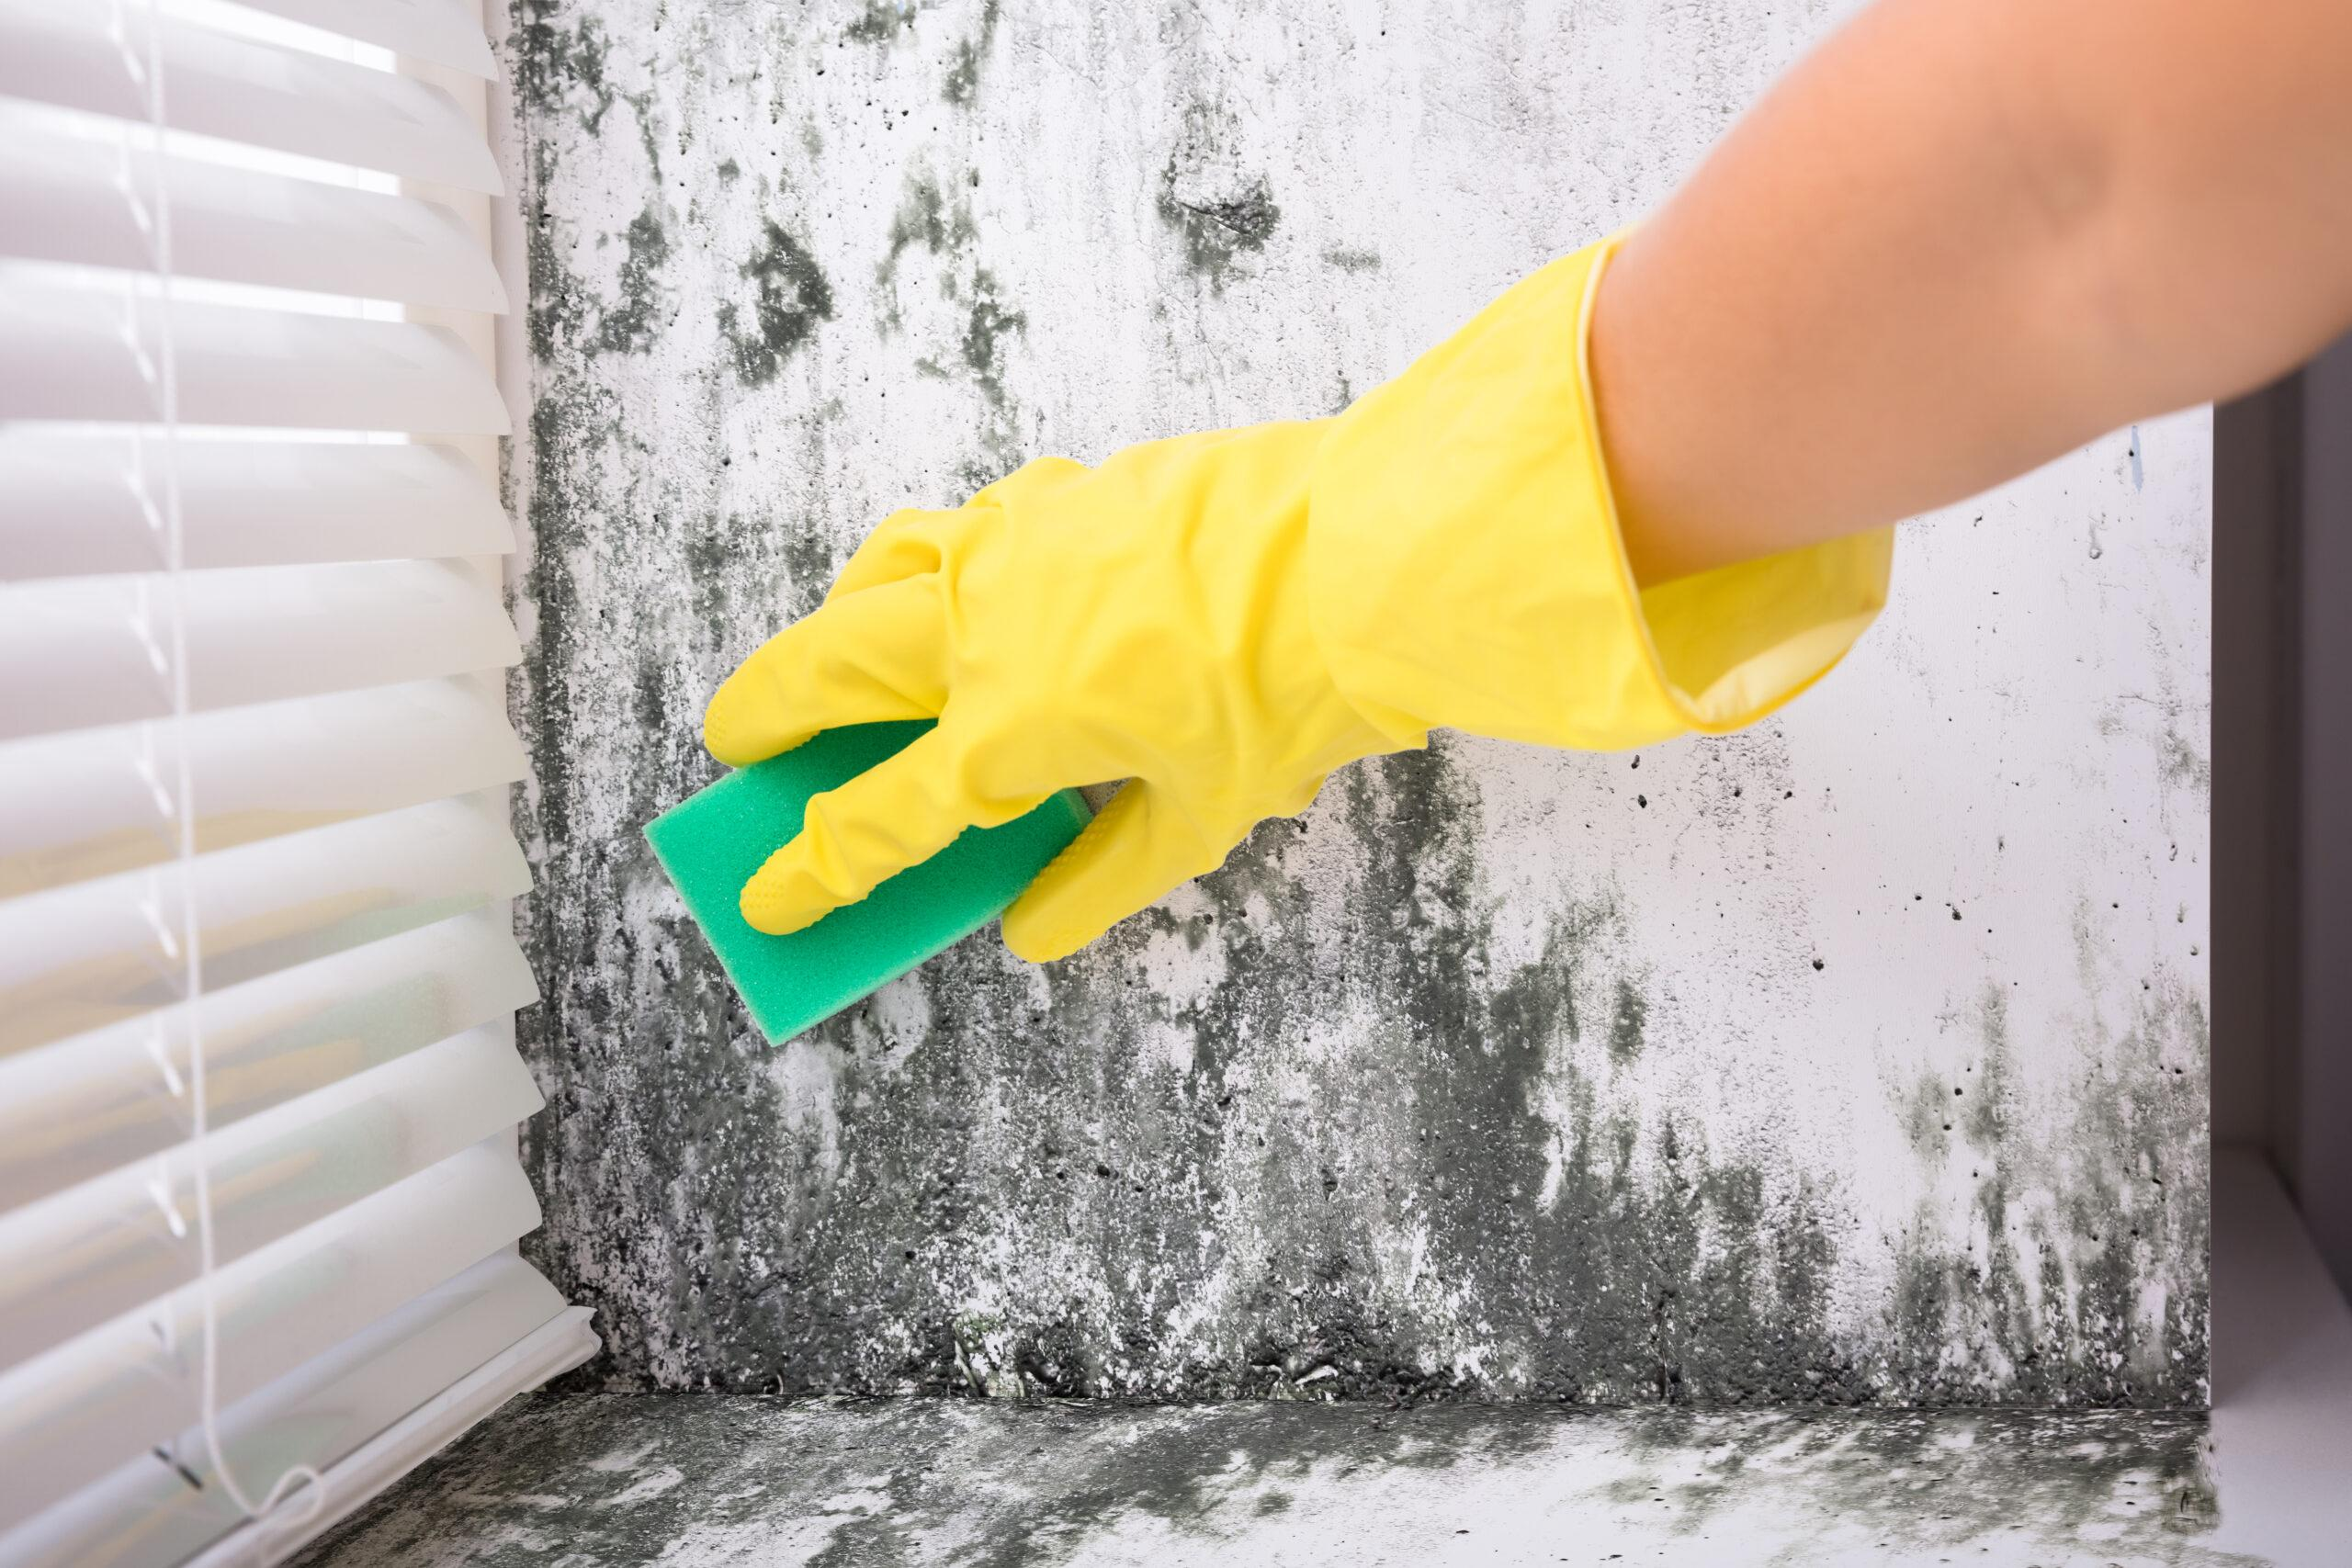

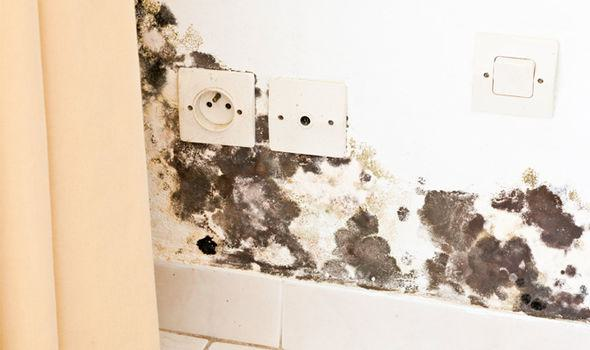

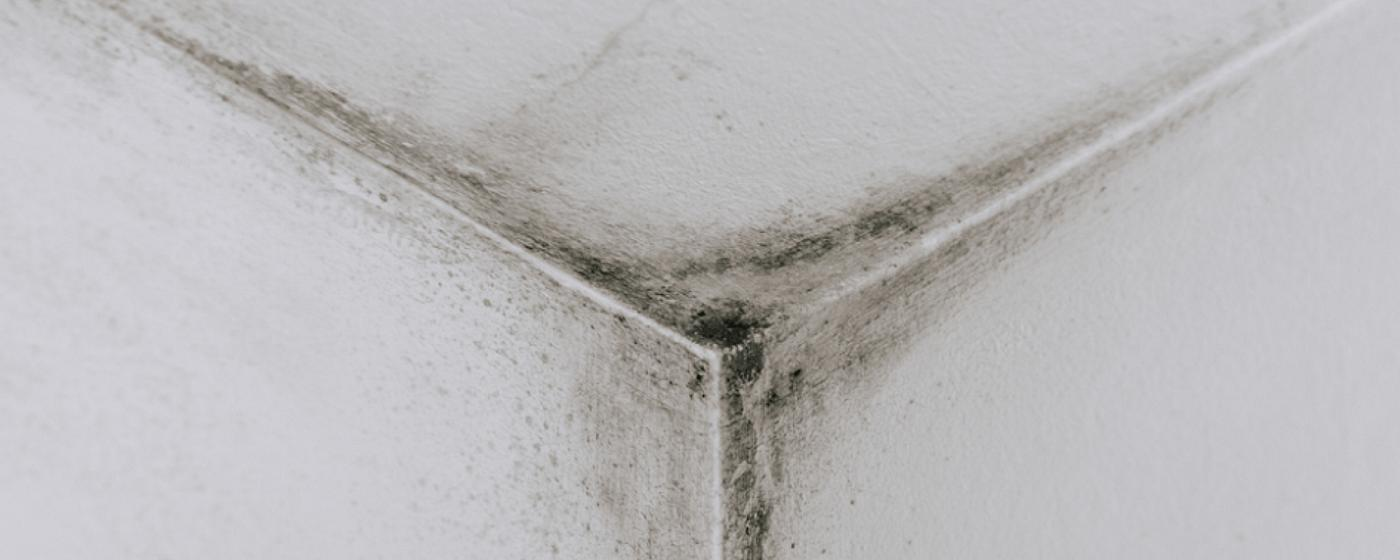

In [2]:
image_dir = 'data/MouldImages/train/mould/'
files = listdir(image_dir)
img_paths = [join(image_dir, f) for f in files [0:9]]

for i, img_path in enumerate (img_paths):
    display(Image(img_path, width=224, height=224))

In [3]:
# Define image size and batch size
img_size = [224, 224]
batch_size = 32

In [4]:
# Load VGG-16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape= img_size + [3])
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [5]:
# Freeze VGG-16 layers
for layer in base_model.layers:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Set up data generators for training and validation sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
train_gen = train_datagen.flow_from_directory(
    'data/MouldImages/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_gen = test_datagen.flow_from_directory(
    'data/MouldImages/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

class_names = train_gen.class_indices
print(class_names)

Found 5835 images belonging to 2 classes.
Found 1514 images belonging to 2 classes.
{'clean': 0, 'mould': 1}


In [15]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='models/vgg-16Model_originalMod.h5', verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

# Train model
history = model.fit(train_gen,
                    epochs=100,
                    steps_per_epoch=train_gen.n//train_gen.batch_size,
                    validation_data=test_gen,
                    validation_steps=test_gen.n//test_gen.batch_size,
                    callbacks=callbacks)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
182/182 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9293
Epoch 1: val_loss improved from inf to 0.19624, saving model to models\vgg-16Model_originalMod.h5
182/182 [==============================] - 222s 1s/step - loss: 0.1843 - accuracy: 0.9293 - val_loss: 0.1962 - val_accuracy: 0.9375
Epoch 2/100
182/182 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9268
Epoch 2: val_loss improved from 0.19624 to 0.18406, saving model to models\vgg-16Model_originalMod.h5
182/182 [==============================] - 210s 1s/step - loss: 0.1817 - accuracy: 0.9268 - val_loss: 0.1841 - val_accuracy: 0.9402
Epoch 3/100
182/182 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9293
Epoch 3: val_loss did not improve from 0.18406
182/182 [==============================] - 210s 1s/step - loss: 0.1806 - accuracy: 0.9293 - val_loss: 0.2027 - val_accuracy: 0.9309
Epoch 4/100
182/182 [==============================] - ETA: 0s - l

Found 1514 images belonging to 2 classes.
1514/1514 [==============================] - 42s 27ms/step
Normalized confusion matrix
[[0.57463672 0.42536328]
 [0.5680317  0.4319683 ]]


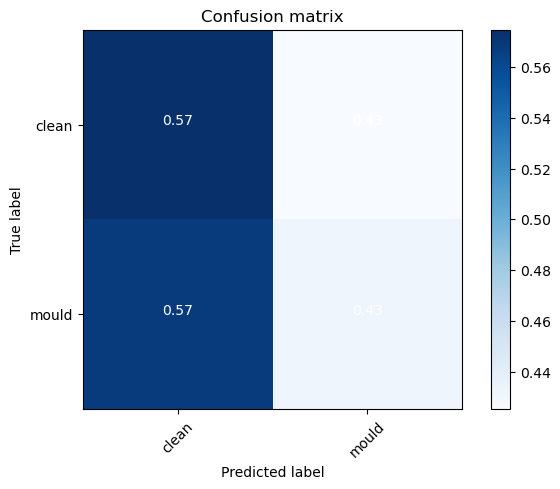

In [16]:
 #Load saved model
from keras.models import load_model
model = load_model('models/vgg-16Model_originalMod.h5')

# Set up data generator for test set
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    'data/MouldImages/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

# Make predictions for test set
test_gen.reset()
pred = model.predict(test_gen, steps=test_gen.n, verbose=1)

# Get true labels for test set
test_labels = test_gen.classes

# Get predicted labels for test set
pred_labels = np.argmax(pred, axis=1)

# Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, pred_labels)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
plot_confusion_matrix(cm, classes=['clean', 'mould'], normalize=True,
                      title='Confusion matrix')


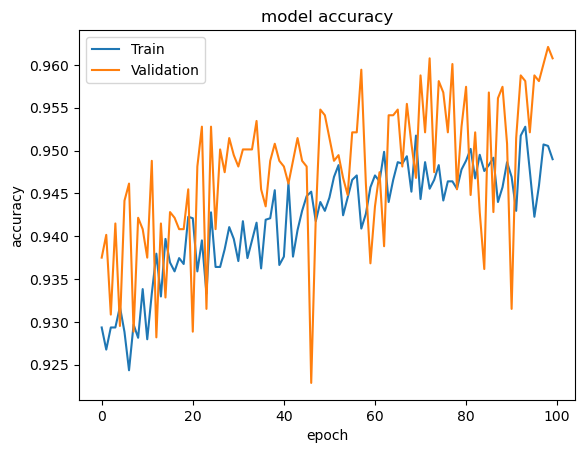

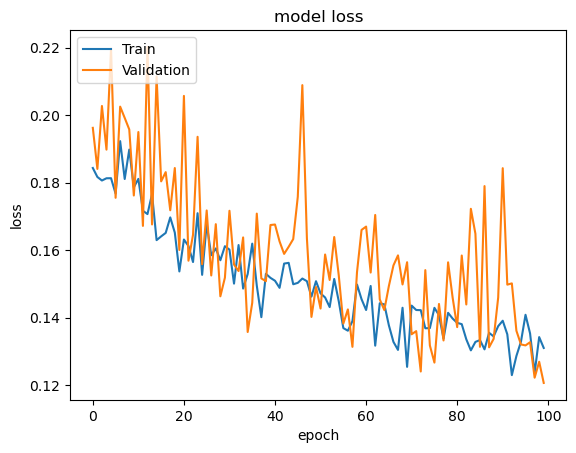

In [17]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
# Load saved model
from keras.models import load_model
model = load_model('models/vgg-16Model_originalMod.h5')

# Predict on single image, by also showing the image
def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    pred = model.predict(img_tensor)
    print(pred)
    plt.show()


1/1 [==============================] - 0s 324ms/step
[[0.8697312  0.13026878]]


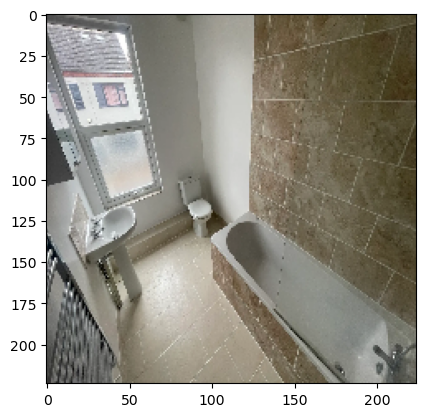

In [21]:
predict_single_image('test images for mould/test1.jpg')

1/1 [==============================] - 0s 304ms/step


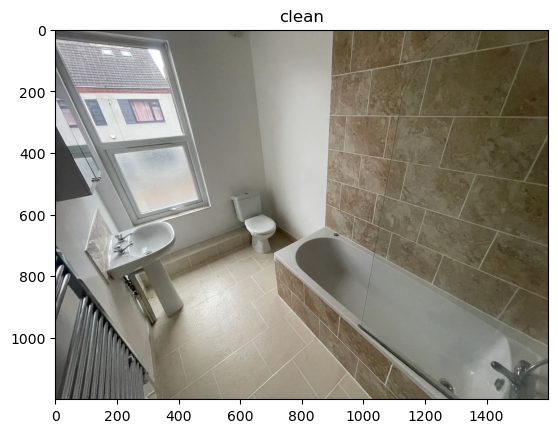

1/1 [==============================] - 0s 38ms/step


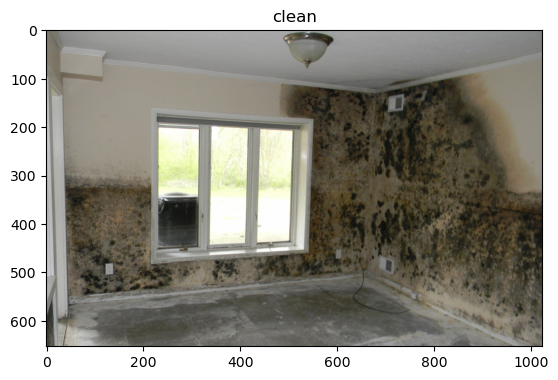

1/1 [==============================] - 0s 37ms/step


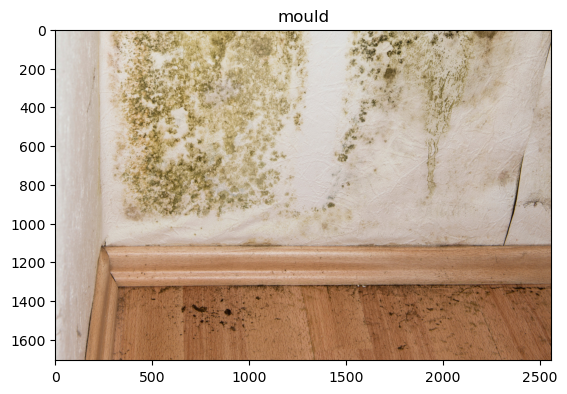

1/1 [==============================] - 0s 41ms/step


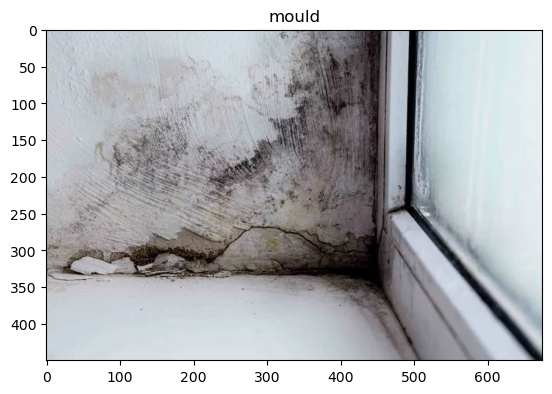

1/1 [==============================] - 0s 50ms/step


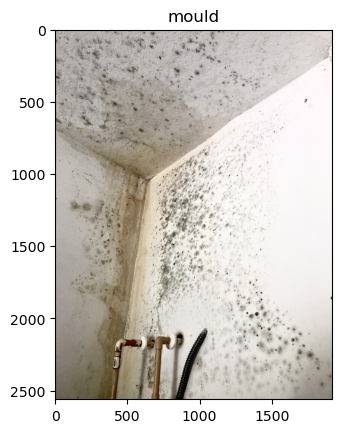

1/1 [==============================] - 0s 41ms/step


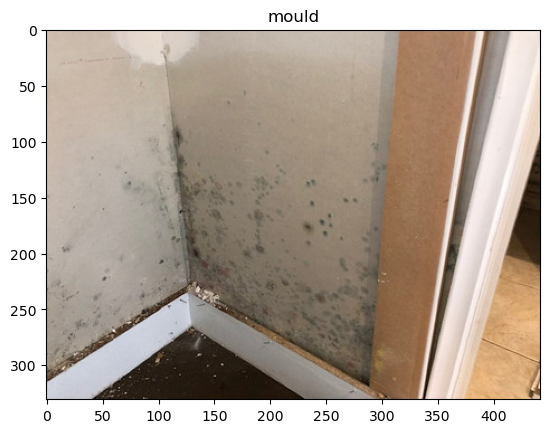

1/1 [==============================] - 0s 45ms/step


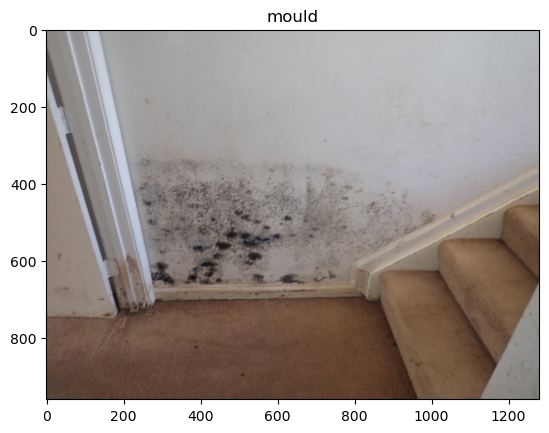

1/1 [==============================] - 0s 48ms/step


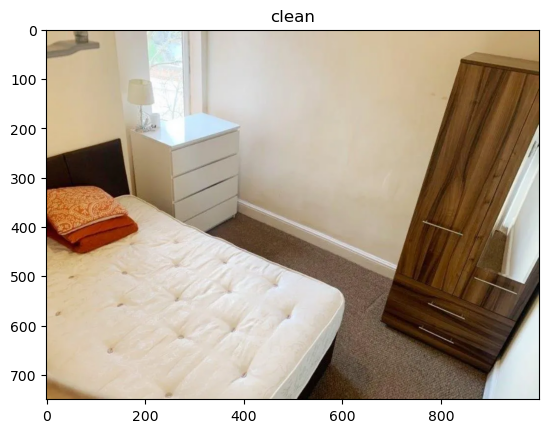

1/1 [==============================] - 0s 38ms/step


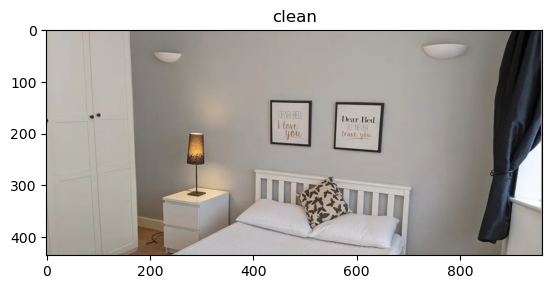

1/1 [==============================] - 0s 39ms/step


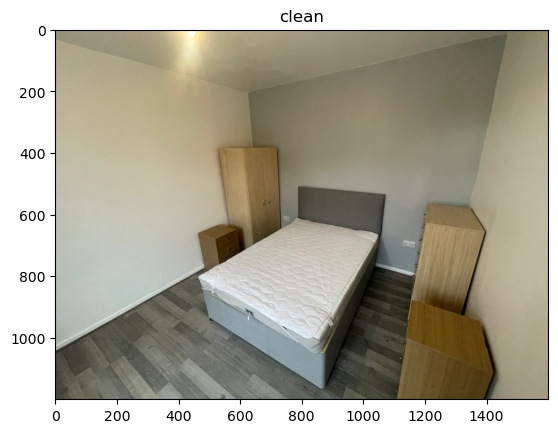

1/1 [==============================] - 0s 35ms/step


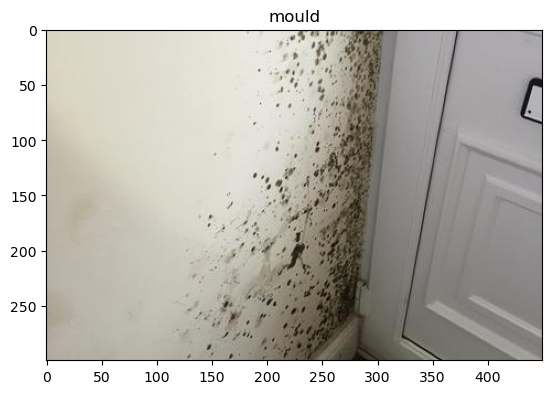

1/1 [==============================] - 0s 37ms/step


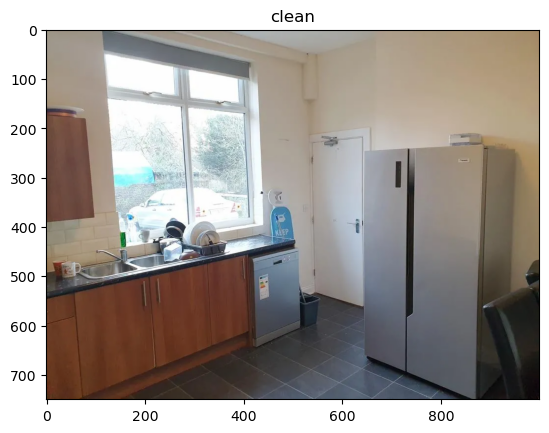

1/1 [==============================] - 0s 39ms/step


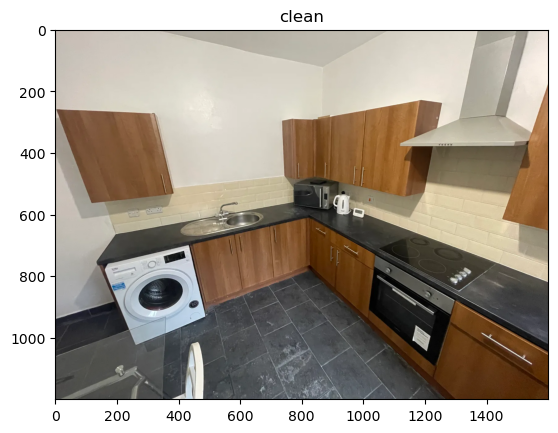

1/1 [==============================] - 0s 42ms/step


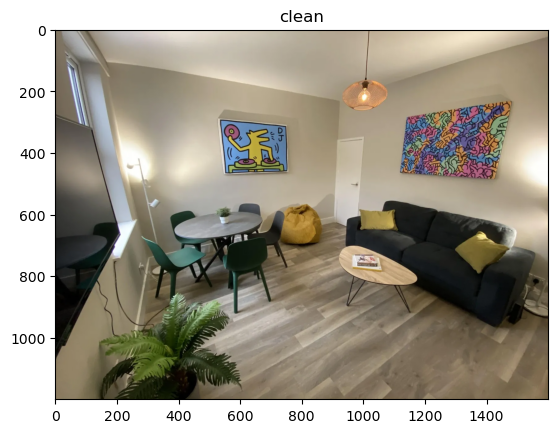

1/1 [==============================] - 0s 37ms/step


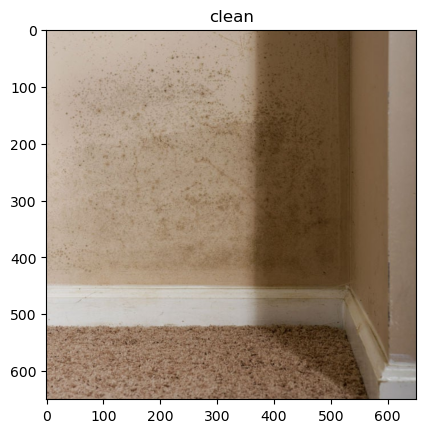

In [22]:
# Import necessary libraries
import keras.utils as image
import numpy as np
import matplotlib.pyplot as plt
import itertools
import cv2
from os import listdir
from os.path import isfile, join
from IPython.display import Image, display

image_dir = 'test images for mould/'
files = listdir(image_dir)
img_paths = [join(image_dir, f) for f in files]

# Load saved model
from keras.models import load_model

model = load_model('models/vgg-16Model_binary.h5')

# Predict on images in folder, by also showing the image
for i, img_path in enumerate(img_paths):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    pred = model.predict(img_tensor)
    print(pred)

    if pred[0][0] > pred[0][1]:
        result = 'clean'
    else:
        result = 'mould'
    plt.title(result)
    plt.show()

1/1 [==============================] - 0s 271ms/step


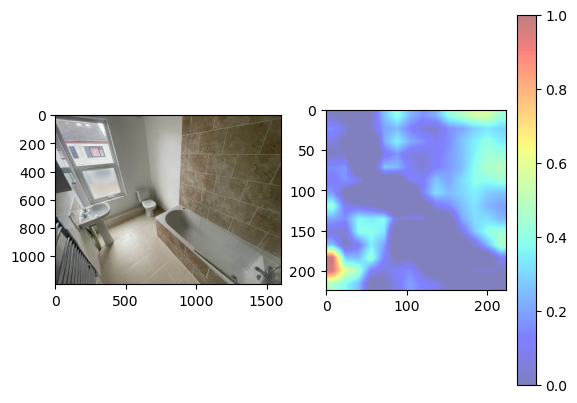

1/1 [==============================] - 0s 38ms/step


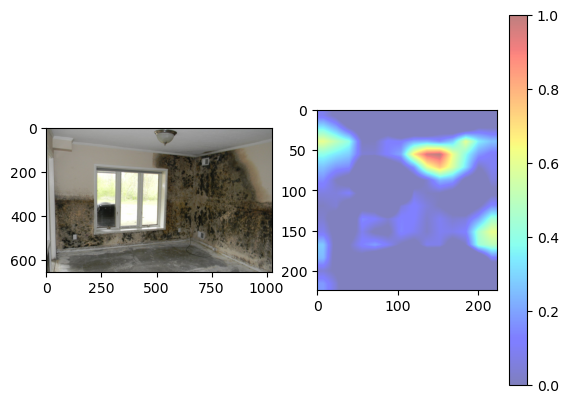

1/1 [==============================] - 0s 40ms/step


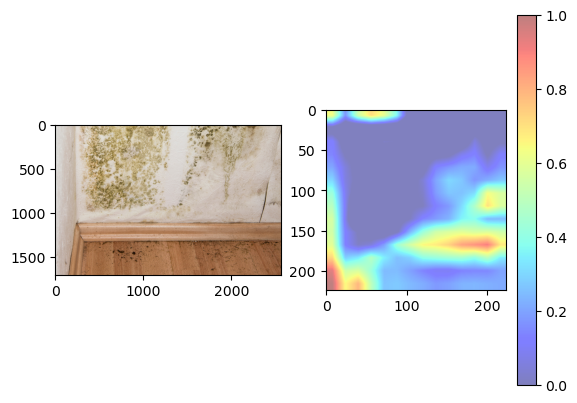

1/1 [==============================] - 0s 36ms/step


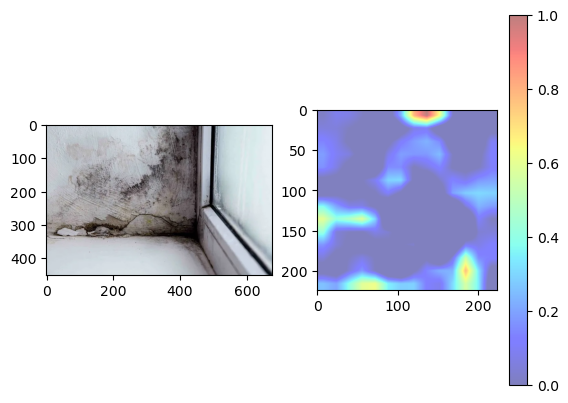

1/1 [==============================] - 0s 48ms/step


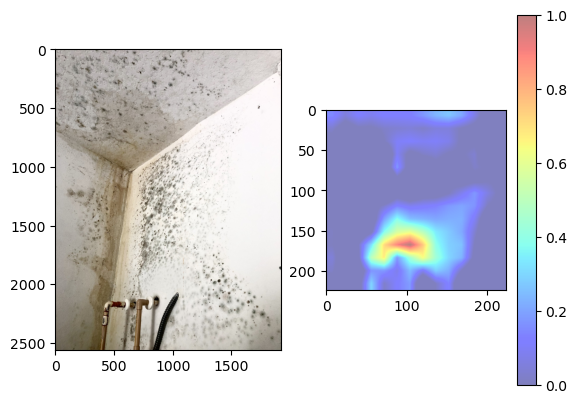

1/1 [==============================] - 0s 36ms/step


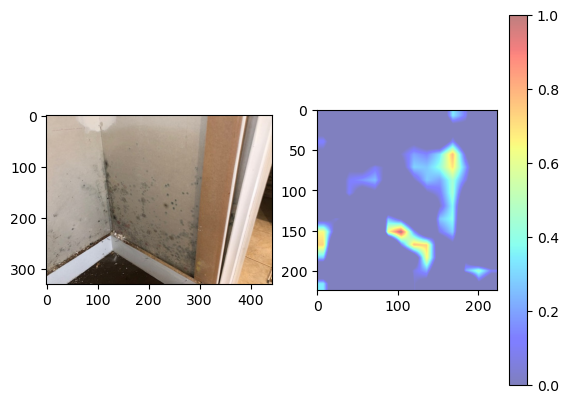

1/1 [==============================] - 0s 46ms/step


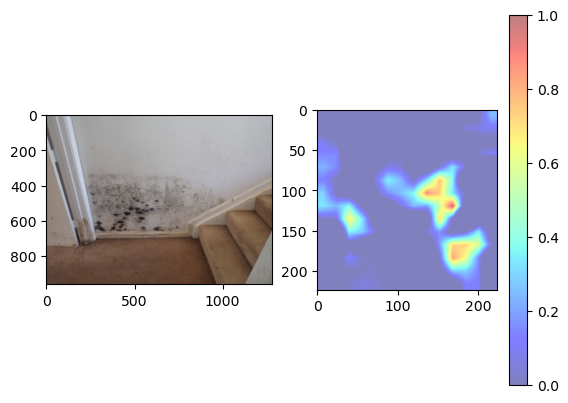

1/1 [==============================] - 0s 36ms/step


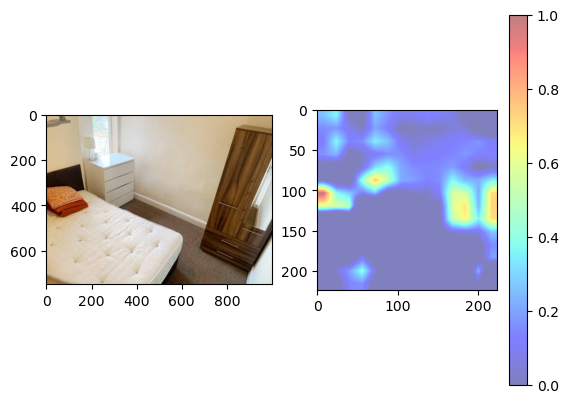

1/1 [==============================] - 0s 42ms/step


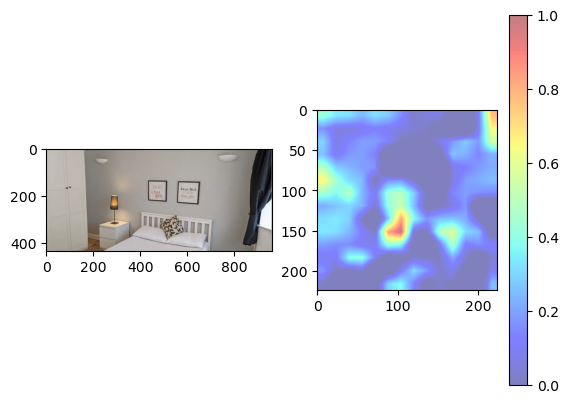

1/1 [==============================] - 0s 37ms/step


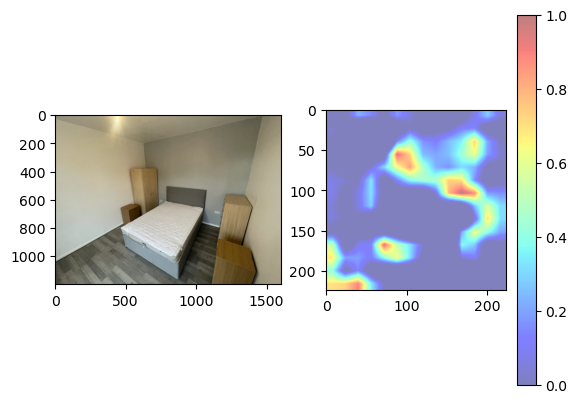

1/1 [==============================] - 0s 36ms/step


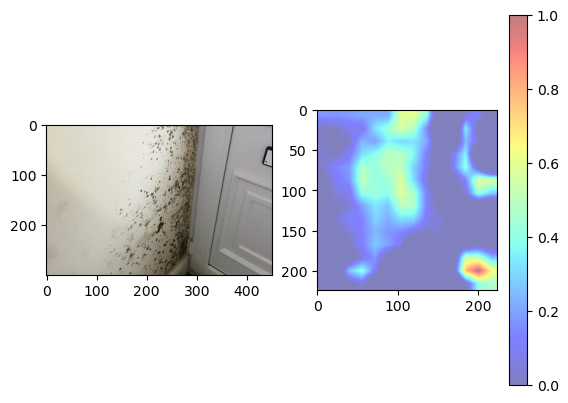

1/1 [==============================] - 0s 36ms/step


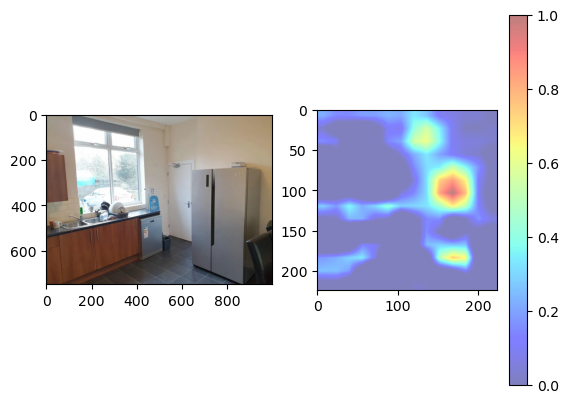

1/1 [==============================] - 0s 37ms/step


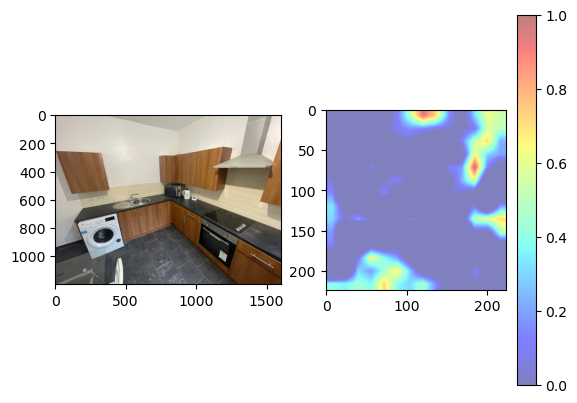

1/1 [==============================] - 0s 40ms/step


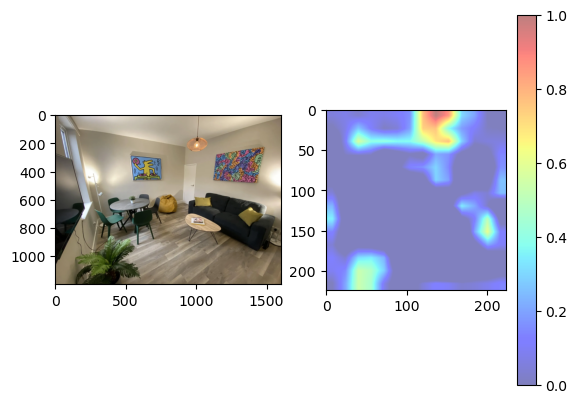

1/1 [==============================] - 0s 34ms/step


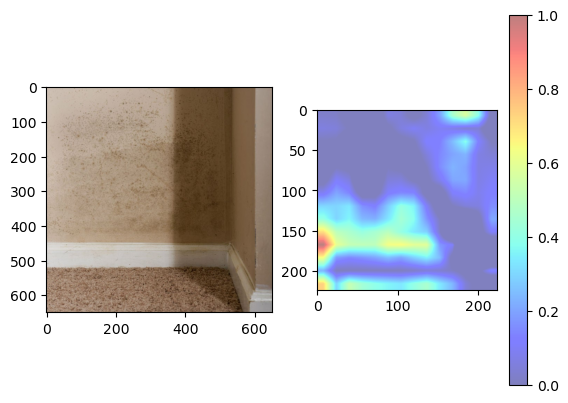

In [23]:
# Load saved model
from keras.models import load_model
model = load_model('models/vgg-16Model_originalMod.h5')

# Define new model that outputs the output of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')
new_model = Model(model.input, last_conv_layer.output)

# Define function that generates class activation map for given image path
def generate_cam(image_path):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get output of last convolutional layer and class predictions
    last_conv_output = new_model.predict(x)
    preds = model.predict(x)

    # Get predicted class index and calculate class activation map
    class_idx = np.argmax(preds[0])
    cam = np.zeros((last_conv_output.shape[1], last_conv_output.shape[2]), dtype=np.float32)
    for i, w in enumerate(model.layers[-1].get_weights()[0][:, class_idx]):
        cam += w * last_conv_output[0, :, :, i]

    # Resize and normalize class activation map
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    cam /= cam.max()

    # Load and display original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    # Display class activation map
    plt.subplot(1, 2, 2)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()

# Get list of image paths
image_dir = 'test images for mould/'
files = listdir(image_dir)
img_paths = [join(image_dir, f) for f in files]

# Generate and display CAM for each image in folder
for img_path in img_paths:
    generate_cam(img_path)